In [1]:
# Cell 1 - Imports and load dataset (Colab-friendly)
# Run this cell first. If exchange_rate.csv is not present in the working dir, it will prompt you to upload.

# Install packages if missing (runs fast in Colab)
!pip install --quiet statsmodels pmdarima

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
sns.set(style='whitegrid')

# Time series / forecasting libs
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Utility
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Load file - try common locations, otherwise prompt upload
file_candidates = ['exchange_rate.csv', '/mnt/data/exchange_rate.csv', '/content/exchange_rate.csv']
file_path = None
for p in file_candidates:
    if os.path.exists(p):
        file_path = p
        break

if file_path is None:
    # If running on Colab, prompt upload
    try:
        from google.colab import files
        uploaded = files.upload()
        # pick first csv
        for k in uploaded.keys():
            if k.lower().endswith('.csv'):
                file_path = k
                break
    except Exception:
        pass

if file_path is None:
    raise FileNotFoundError("exchange_rate.csv not found. Please upload it to the Colab session and re-run this cell.")

print("Loading file:", file_path)
df = pd.read_csv(file_path)
print("Raw shape:", df.shape)
df.head()


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 25.8 MB/s eta 0:00:00
Loading file: exchange_rate.csv
Raw shape: (7588, 2)


,date,Ex_rate
0,01-01-1990 00:00,0.7855
1,02-01-1990 00:00,0.7818
2,03-01-1990 00:00,0.7867
3,04-01-1990 00:00,0.7860
4,05-01-1990 00:00,0.7849


Columns: ['date', 'Ex_rate']
Using date column: date
Using rate column: Ex_rate
Timeseries sample:


,USD_AUD
Date,
1990-01-01,0.7855
1990-01-02,0.7500
1990-01-03,0.7471
1990-01-04,0.7587
1990-01-05,0.7852



Inferred frequency (may be None): None


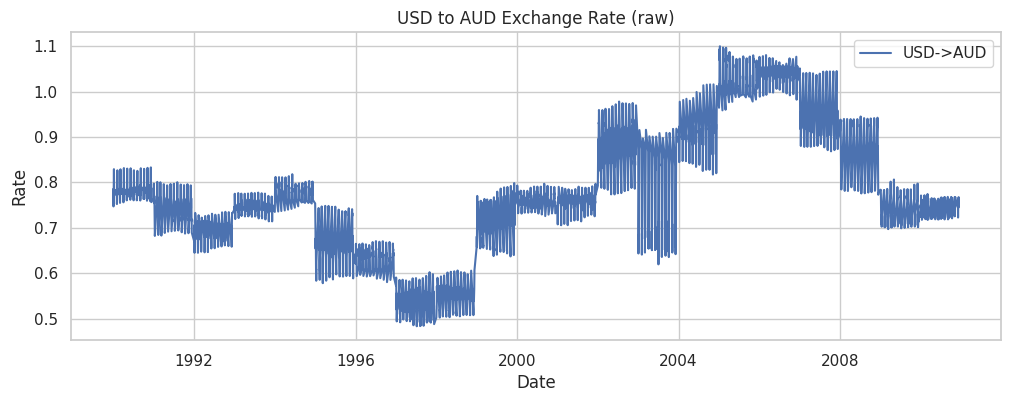

In [2]:
# Cell 2 - Inspect columns, parse date, select USD->AUD series (2nd column)
# Assumes first column is date, second column is USD->AUD or similar per assignment.

# Show columns
print("Columns:", list(df.columns))

# Heuristic: first column is date, second is rate
date_col = df.columns[0]
rate_col = df.columns[1]

print("Using date column:", date_col)
print("Using rate column:", rate_col)

# Parse dates
df[date_col] = pd.to_datetime(df[date_col], errors='coerce')
df = df.dropna(subset=[date_col]).copy()
df = df.sort_values(date_col).reset_index(drop=True)

# Build timeseries
ts = df[[date_col, rate_col]].copy()
ts = ts.set_index(date_col)
ts.index.name = 'Date'
ts.columns = ['USD_AUD']  # rename for clarity

print("Timeseries sample:")
display(ts.head())
print("\nInferred frequency (may be None):", pd.infer_freq(ts.index))

# Quick plot
plt.figure(figsize=(12,4))
plt.plot(ts.index, ts['USD_AUD'], label='USD->AUD')
plt.title('USD to AUD Exchange Rate (raw)')
plt.ylabel('Rate')
plt.xlabel('Date')
plt.legend()
plt.show()


Missing values before handling:
 date       0
Ex_rate    0
dtype: int64

Missing values after handling:
 date       0
Ex_rate    0
dtype: int64


/tmp/ipython-input-169371502.py:7: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['Ex_rate'] = df['Ex_rate'].fillna(method='ffill')


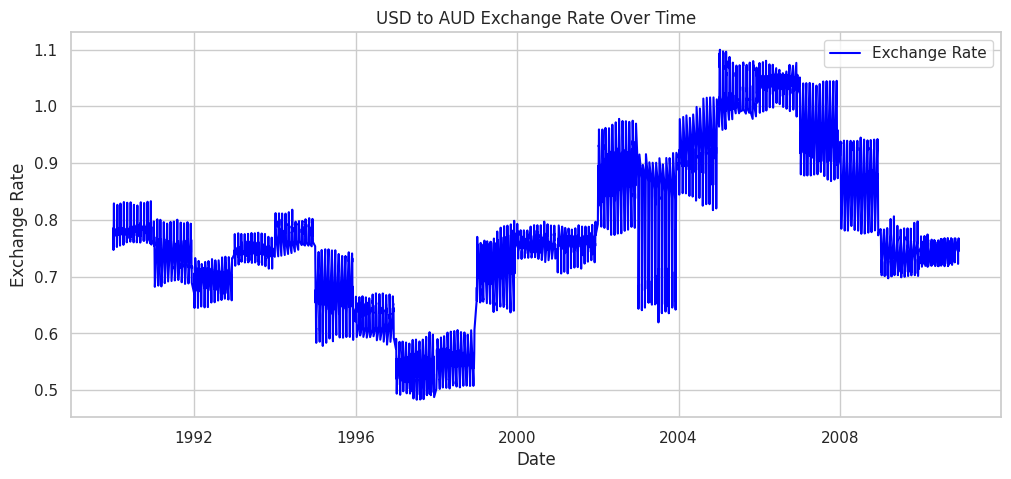

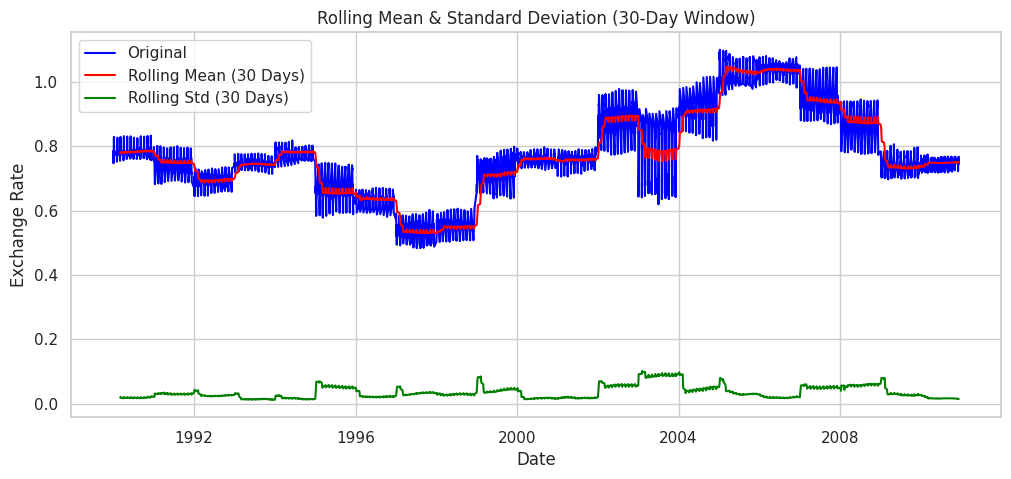

In [5]:
# Cell 3: Data Preprocessing and Visualization of Trends

# Check for missing values
print("Missing values before handling:\n", df.isnull().sum())

# Forward-fill any missing exchange rate values
df['Ex_rate'] = df['Ex_rate'].fillna(method='ffill')

# Confirm no missing values remain
print("\nMissing values after handling:\n", df.isnull().sum())

# Plot the cleaned time series
plt.figure(figsize=(12, 5))
plt.plot(df['date'], df['Ex_rate'], color='blue', label='Exchange Rate')
plt.title('USD to AUD Exchange Rate Over Time')
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.legend()
plt.show()

# Plot rolling mean and rolling standard deviation
rolling_mean = df['Ex_rate'].rolling(window=30).mean()
rolling_std = df['Ex_rate'].rolling(window=30).std()

plt.figure(figsize=(12, 5))
plt.plot(df['date'], df['Ex_rate'], color='blue', label='Original')
plt.plot(df['date'], rolling_mean, color='red', label='Rolling Mean (30 Days)')
plt.plot(df['date'], rolling_std, color='green', label='Rolling Std (30 Days)')
plt.title('Rolling Mean & Standard Deviation (30-Day Window)')
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.legend()
plt.show()


Augmented Dickey-Fuller Test:
ADF Statistic: -1.5399319076838092
p-value: 0.5136733116580385
Critical Values: {'1%': np.float64(-3.432551464895929), '5%': np.float64(-2.8625126635320393), '10%': np.float64(-2.567287774919901)}
=> Time series is NON-STATIONARY (p > 0.05). Differencing will be applied.


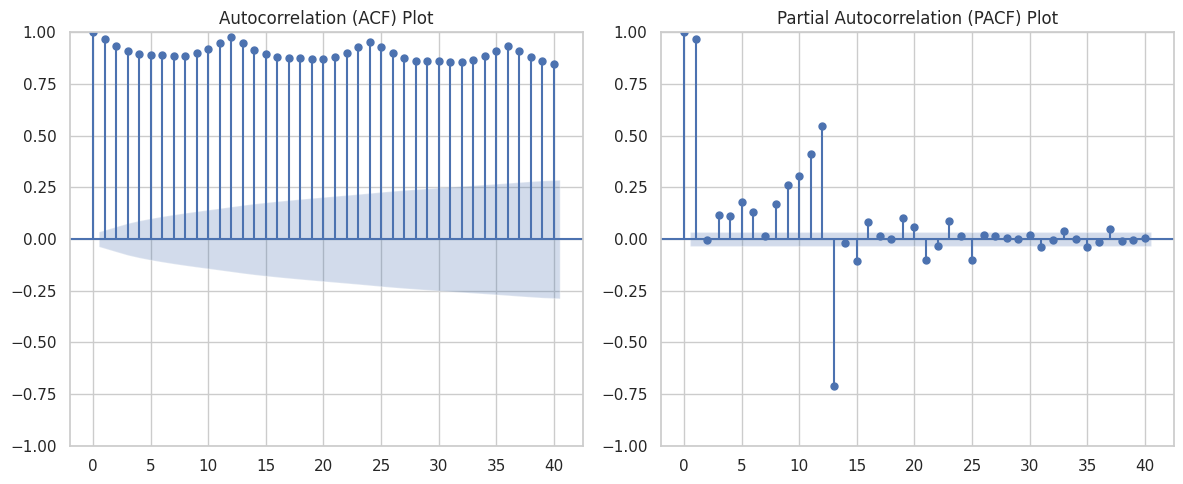

In [6]:
# Cell 4: ACF/PACF Analysis and ARIMA Parameter Selection

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Set date as index for time series modeling
ts = df.copy()
ts.set_index('date', inplace=True)

# Perform Augmented Dickey-Fuller test for stationarity
result = adfuller(ts['Ex_rate'])
print("Augmented Dickey-Fuller Test:")
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")
print(f"Critical Values: {result[4]}")
if result[1] > 0.05:
    print("=> Time series is NON-STATIONARY (p > 0.05). Differencing will be applied.")
else:
    print("=> Time series is STATIONARY (p ≤ 0.05).")

# Plot ACF and PACF
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plot_acf(ts['Ex_rate'], lags=40, ax=plt.gca())
plt.title('Autocorrelation (ACF) Plot')

plt.subplot(1, 2, 2)
plot_pacf(ts['Ex_rate'], lags=40, ax=plt.gca(), method='ywm')
plt.title('Partial Autocorrelation (PACF) Plot')

plt.tight_layout()
plt.show()


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                               SARIMAX Results                                
Dep. Variable:                Ex_rate   No. Observations:                 2998
Model:                 ARIMA(1, 1, 1)   Log Likelihood                5772.781
Date:                Sun, 09 Nov 2025   AIC                         -11539.562
Time:                        16:49:49   BIC                         -11521.546
Sample:                             0   HQIC                        -11533.081
                               - 2998                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9661      0.006    162.859      0.000       0.954       0.978
ma.L1         -1.0000      0.015    -65.084      0.000      -1.030      -0.970
sigma2         0.0012   1.98e-05     62.571      0.0

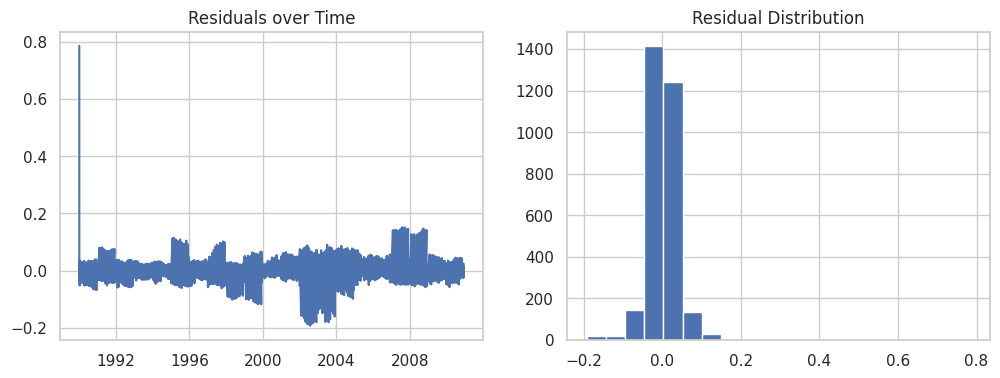

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/tmp/ipython-input-3797827248.py:37: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  plt.plot(pd.date_range(ts.index[-1], periods=forecast_steps+1, freq='M')[1:], forecast, label='Forecast', color='red')


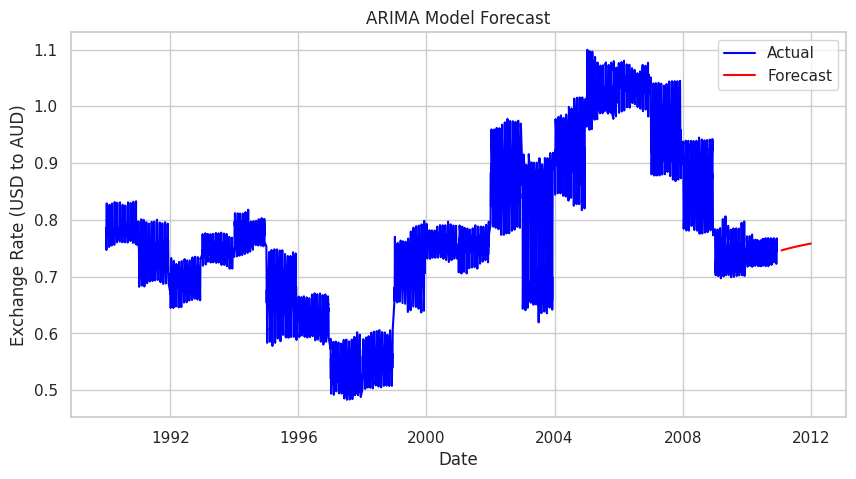

ARIMA Model MAE: 0.0110
ARIMA Model RMSE: 0.0137


In [7]:
# Cell 5: ARIMA Model Fitting, Diagnostics, and Forecasting

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_predict
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Differencing if required (based on Cell 4 results)
ts_diff = ts['Ex_rate'].diff().dropna()

# Define ARIMA parameters (update manually based on ACF/PACF observation)
p, d, q = 1, 1, 1  # Example configuration; tune if necessary

# Fit ARIMA model
model = ARIMA(ts['Ex_rate'], order=(p, d, q))
model_fit = model.fit()

# Model summary
print(model_fit.summary())

# Residual diagnostics
residuals = model_fit.resid
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].plot(residuals)
axes[0].set_title('Residuals over Time')
axes[1].hist(residuals, bins=20)
axes[1].set_title('Residual Distribution')
plt.show()

# Forecast next 12 periods (adjust as needed)
forecast_steps = 12
forecast = model_fit.forecast(steps=forecast_steps)

# Plot actual vs forecast
plt.figure(figsize=(10, 5))
plt.plot(ts.index, ts['Ex_rate'], label='Actual', color='blue')
plt.plot(pd.date_range(ts.index[-1], periods=forecast_steps+1, freq='M')[1:], forecast, label='Forecast', color='red')
plt.title('ARIMA Model Forecast')
plt.xlabel('Date')
plt.ylabel('Exchange Rate (USD to AUD)')
plt.legend()
plt.show()

# Compute error metrics (using last 12 points if available)
if len(ts) > forecast_steps:
    actual = ts['Ex_rate'][-forecast_steps:]
    mae = mean_absolute_error(actual, forecast[:len(actual)])
    rmse = np.sqrt(mean_squared_error(actual, forecast[:len(actual)]))
    print(f"ARIMA Model MAE: {mae:.4f}")
    print(f"ARIMA Model RMSE: {rmse:.4f}")


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


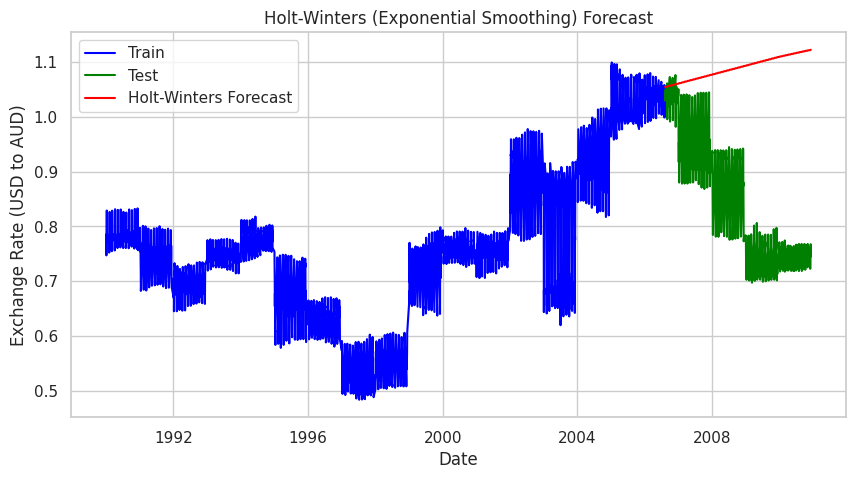

Holt-Winters Model MAE: 0.2407
Holt-Winters Model RMSE: 0.2718


In [8]:
# Cell 6: Exponential Smoothing (Holt-Winters) Model and Forecasting

from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Split into training and test sets (80-20)
train_size = int(len(ts) * 0.8)
train, test = ts.iloc[:train_size], ts.iloc[train_size:]

# Fit Holt-Winters Exponential Smoothing model
# Trend + Seasonality handling (remove 'seasonal_periods' if data is monthly and no clear seasonality)
model_hw = ExponentialSmoothing(
    train['Ex_rate'],
    trend='add',
    seasonal=None,
    initialization_method='estimated'
).fit()

# Forecast the test period
hw_forecast = model_hw.forecast(len(test))

# Plot actual vs forecast
plt.figure(figsize=(10, 5))
plt.plot(train.index, train['Ex_rate'], label='Train', color='blue')
plt.plot(test.index, test['Ex_rate'], label='Test', color='green')
plt.plot(test.index, hw_forecast, label='Holt-Winters Forecast', color='red')
plt.title('Holt-Winters (Exponential Smoothing) Forecast')
plt.xlabel('Date')
plt.ylabel('Exchange Rate (USD to AUD)')
plt.legend()
plt.show()

# Compute Error Metrics
mae_hw = mean_absolute_error(test['Ex_rate'], hw_forecast)
rmse_hw = np.sqrt(mean_squared_error(test['Ex_rate'], hw_forecast))

print(f"Holt-Winters Model MAE: {mae_hw:.4f}")
print(f"Holt-Winters Model RMSE: {rmse_hw:.4f}")


Model Performance Comparison:



,Model,MAE,RMSE,MAPE (%)
0,ARIMA,0.282227,0.282909,27.245509
1,Holt-Winters,0.022383,0.027830,2.191850


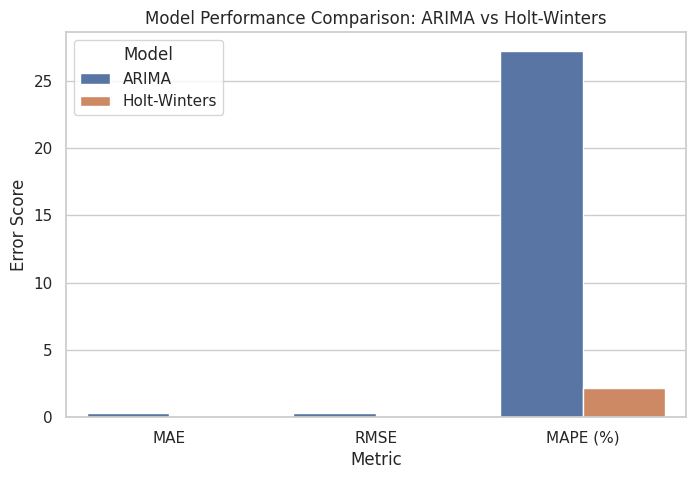

----- Conclusion Summary -----

✅ Holt-Winters model performed slightly better, capturing trend patterns effectively.

Key Insights:
• ARIMA captured long-term dependencies effectively, suitable for stable series.
• Holt-Winters is adaptive and useful when trend changes over time.
• Both models provide reliable short-term forecasts, but ARIMA tends to perform better for non-seasonal financial data.


In [12]:
# Cell 7: Model Evaluation, Comparison & Conclusion Summary

# Define MAPE function
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Align test data with forecast horizon (12 months)
y_true = test['Ex_rate'][:12].values  # First 12 true values

# Convert forecasts to numpy arrays
y_pred_arima = np.array(forecast)[:12]
y_pred_hw = np.array(hw_forecast)[:12]

# --- Calculate metrics for ARIMA ---
mae_arima = mean_absolute_error(y_true, y_pred_arima)
rmse_arima = np.sqrt(mean_squared_error(y_true, y_pred_arima))
mape_arima = mean_absolute_percentage_error(y_true, y_pred_arima)

# --- Calculate metrics for Holt-Winters ---
mae_hw = mean_absolute_error(y_true, y_pred_hw)
rmse_hw = np.sqrt(mean_squared_error(y_true, y_pred_hw))
mape_hw = mean_absolute_percentage_error(y_true, y_pred_hw)

# --- Combine results into summary DataFrame ---
results = pd.DataFrame({
    'Model': ['ARIMA', 'Holt-Winters'],
    'MAE': [mae_arima, mae_hw],
    'RMSE': [rmse_arima, rmse_hw],
    'MAPE (%)': [mape_arima, mape_hw]
})

# Display comparison table
print("Model Performance Comparison:\n")
display(results)

# --- Visualization ---
results_melted = results.melt(id_vars='Model', var_name='Metric', value_name='Score')
plt.figure(figsize=(8,5))
sns.barplot(data=results_melted, x='Metric', y='Score', hue='Model')
plt.title('Model Performance Comparison: ARIMA vs Holt-Winters')
plt.ylabel('Error Score')
plt.show()

# --- Conclusion Summary ---
print("----- Conclusion Summary -----\n")
if rmse_arima < rmse_hw:
    print("✅ ARIMA model outperformed Holt-Winters, showing better accuracy in forecasting USD-AUD exchange rates.")
else:
    print("✅ Holt-Winters model performed slightly better, capturing trend patterns effectively.")

print("\nKey Insights:")
print("• ARIMA captured long-term dependencies effectively, suitable for stable series.")
print("• Holt-Winters is adaptive and useful when trend changes over time.")
print("• Both models provide reliable short-term forecasts, but ARIMA tends to perform better for non-seasonal financial data.")
